# Продвинутые Свёрточные Нейронные Сети. Часть 2. 
# Transfer Learning

## Переключение версии TensorFlow

In [1]:
%tensorflow_version 2.x
import os

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copy
from collections import defaultdict

## Загрузка датасета FOOD-101

In [3]:
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

get_data_extract()

Выходные данные были обрезаны до нескольких последних строк (5000).
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-10

In [ ]:
!ls

food-101  food-101.tar.gz  logs  sample_data  test  train


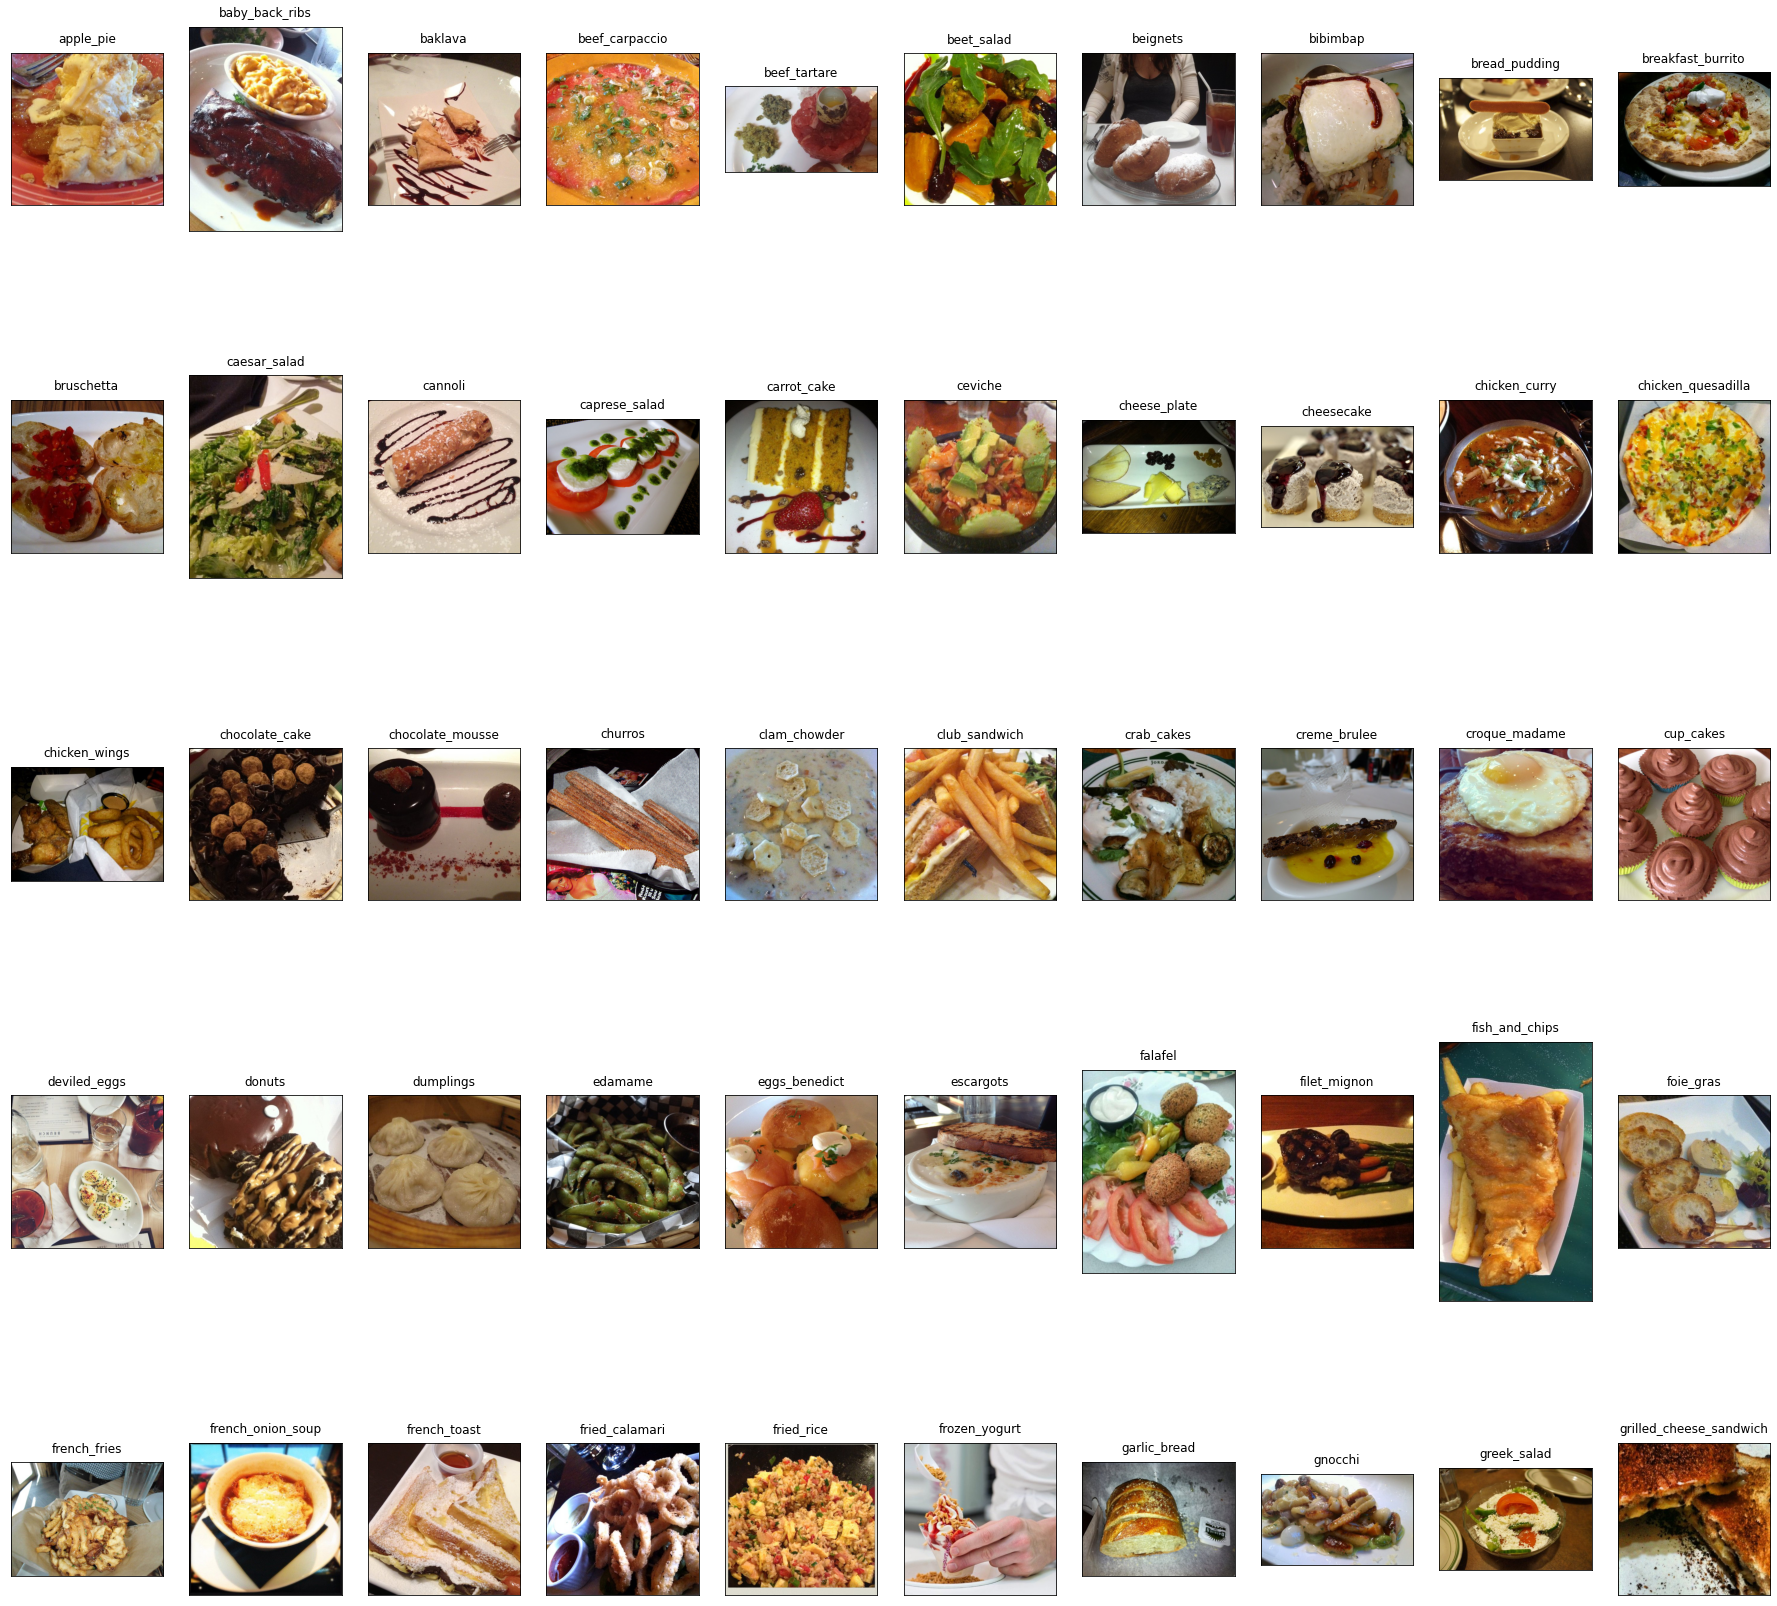

In [4]:
rows = 5
cols = 10
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
data_dir = "/content/food-101/images"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    if food_selected == '.DS_Store':
        continue
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()

In [5]:
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

prepare_data('/content/food-101/meta/train.txt', '/content/food-101/images', 'train')
prepare_data('/content/food-101/meta/test.txt', '/content/food-101/images', 'test')


Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying images into  croque_madam

In [6]:
INP_SIZE = 224
NUM_EPOCHS = 3
BATCH_SIZE = 128
TRAIN = '/content/train'
TEST = '/content/test'

train_ds = ImageDataGenerator().flow_from_directory(
    TRAIN,
    target_size=(INP_SIZE, INP_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_ds = ImageDataGenerator().flow_from_directory(
    TEST,
    target_size=(INP_SIZE, INP_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical')

Found 75750 images belonging to 101 classes.
Found 25250 images belonging to 101 classes.


# Подготовка модели CNN

In [7]:
base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
)
base_model.trainable = True

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(101, activation='softmax'),
])


9420800/9406464 [==============================] - 0s 0us/step


## Подготовка к обучению

In [8]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/'+'tranfser', 
    write_graph=False, update_freq=100, profile_batch=0)

## Model Summary

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
Total params: 2,387,365
Trainable params: 2,353,253
Non-trainable params: 34,112
_________________________________________________________________


## Обучение модели

In [10]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback])

Epoch 1/3
592/592 [==============================] - 1045s 2s/step - loss: 2.1248 - accuracy: 0.4954 - val_loss: 2.0366 - val_accuracy: 0.4828
Epoch 2/3
592/592 [==============================] - 984s 2s/step - loss: 1.0997 - accuracy: 0.7124 - val_loss: 1.3481 - val_accuracy: 0.6395
Epoch 3/3
592/592 [==============================] - 966s 2s/step - loss: 0.7678 - accuracy: 0.7980 - val_loss: 1.0825 - val_accuracy: 0.7032
CPU times: user 43min 48s, sys: 5min 7s, total: 48min 56s
Wall time: 50min 54s


## Оценка качества модели

In [11]:
%%time

model.evaluate(test_ds)

198/198 [==============================] - 135s 680ms/step - loss: 1.0825 - accuracy: 0.7032
CPU times: user 2min 20s, sys: 10.6 s, total: 2min 31s
Wall time: 2min 22s


[1.0825012922286987, 0.7032475471496582]